In [101]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from facenet_pytorch.models.mtcnn import PNet, RNet, ONet  # Import P-Net, R-Net, O-Net
from facenet_pytorch import MTCNN
import os
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1
import cv2
from sklearn.metrics.pairwise import cosine_similarity
from torch.nn.functional import normalize



In [102]:
match_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Game'  # match photos
studio_images_folder = r'D:\Images\Facial_reco_images\Facial_reco_images\Players\Studio_photos'  # studio photos

In [103]:
# Define fine-tuned P-Net, R-Net, and O-Net for finetuning
class FinetunedMTCNN(MTCNN):
#(self, image_size=160, margin=5, **kwargs): # use this after some time to improve the final results
    def __init__(self, **kwargs):
        super(FinetunedMTCNN, self).__init__(**kwargs)
        # Create your custom, finetuned P-Net, R-Net, O-Net here
        self.pnet = PNet()
        self.rnet = RNet()
        self.onet = ONet()
    def forward(self, x):
        # Overriding forward pass if additional finetuning is needed
        return super().forward(x)

In [104]:
# Initialize FaceNet model
facenet = InceptionResnetV1(pretrained='vggface2').eval()  # Load the FaceNet model
# Initialize mtcnn model
finetuned_mtcnn = FinetunedMTCNN(keep_all=True, device='cuda:0' if torch.cuda.is_available() else 'cpu', min_face_size=60)

In [105]:
def find_euclidean_distance(src, dst):
    return np.linalg.norm(src - dst)

In [106]:
def alignment_procedure(img, left_eye, right_eye):    
    left_eye_x, left_eye_y = left_eye
    right_eye_x, right_eye_y = right_eye
    
    # Find the direction to rotate the image based on the eye coordinates
    if left_eye_y > right_eye_y:
        point_3rd = (right_eye_x, left_eye_y)
        direction = -1  # Clockwise
    else:
        point_3rd = (left_eye_x, right_eye_y)
        direction = 1  # Counter-clockwise
    
    # Calculate the length of the triangle edges
    a = find_euclidean_distance(np.array(left_eye), np.array(point_3rd))
    b = find_euclidean_distance(np.array(right_eye), np.array(point_3rd))
    c = find_euclidean_distance(np.array(left_eye), np.array(right_eye))
    
    # Apply cosine rule to find the angle
    if b != 0 and c != 0:  # Avoid division by zero
        cos_a = (b**2 + c**2 - a**2) / (2 * b * c)
        angle = np.arccos(cos_a)  # Angle in radians
        angle = np.degrees(angle)  # Convert to degrees
        
        # Adjust the angle based on the rotation direction
        if direction == -1:
            angle = 90 - angle
        
        # Rotate the image using PIL
        #img = Image.fromarray(img)
        img = img.rotate(direction * angle, resample=Image.BICUBIC)
        img = np.array(img)  # Convert back to numpy array
        # aligned_img_pil = Image.fromarray(img)  # Convert back to PIL Image for saving
        # aligned_img_pil.show()
    return img

In [107]:
# Function to perform face detection and store image paths with their cropped face regions
def process_and_save_match_faces(image_folder, mtcnn_model, margin=0):
    global match_photos_all
    match_photos_all = []
    match_photos_paths = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            boxes, confidences, landmarks = mtcnn_model.detect(image, landmarks=True)
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.95
                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, confidence in enumerate(confidences) if confidence > threshold]
                #print(f"Number of filtered faces: {len(filtered_faces)}")
                # Process each filtered face
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    box = [int(b) for b in box]  # Ensure the box is in integer format
                    # adding margin around the box
                    # Apply margin to the bounding box
                    x1 = max(0, box[0] - margin)  # Left
                    y1 = max(0, box[1] - margin)  # Top
                    x2 = min(image.width, box[2] + margin)  # Right
                    y2 = min(image.height, box[3] + margin)  # Bottom
                    # Crop the face from the image
                    cropped_face = image.crop((x1, y1, x2, y2))
                    if cropped_face is not None:
                        # Get the landmarks (left and right eyes) for the current face
                        left_eye = landmarks[i][0]  # Left eye coordinates for face i
                        right_eye = landmarks[i][1]  # Right eye coordinates for face i
                        # Align the cropped face using the eye coordinates
                        aligned_face = alignment_procedure(cropped_face, left_eye, right_eye)
                        # Store the aligned face and the original image path
                        match_photos_all.append(aligned_face)
                        match_photos_paths.append(image_path)  # Store original image path
    return match_photos_paths  # Return list of original image paths

In [108]:
def process_and_save_studio_faces(image_folder, mtcnn_model, margin=0):
    global studio_photos_all
    studio_photos_all = []
    studio_photos_paths = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpeg"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            # Detect faces (with bounding boxes, probabilities, and landmarks)
            boxes, confidences, landmarks = mtcnn_model.detect(image, landmarks=True)
            if boxes is not None:
                # Set a confidence threshold
                threshold = 0.95
                # Filter detected faces based on the confidence score
                filtered_faces = [i for i, confidence in enumerate(confidences) if confidence > threshold]
                # Save original image paths and face regions that pass the confidence threshold
                for i in filtered_faces:
                    box = boxes[i]  # Get the bounding box for the filtered face
                    box = [int(b) for b in box]  # Ensure the box is in integer format
                    # Apply margin to the bounding box
                    x1 = max(0, box[0] - margin)  # Left
                    y1 = max(0, box[1] - margin)  # Top
                    x2 = min(image.width, box[2] + margin)  # Right
                    y2 = min(image.height, box[3] + margin)  # Bottom
                    # Crop the face from the image
                    cropped_face = image.crop((x1, y1, x2, y2))
                    if cropped_face is not None:
                        left_eye = landmarks[i][0]
                        #print(left_eye)
                        right_eye = landmarks[i][1]
                        #print(right_eye)
                        aligned_face = alignment_procedure(cropped_face, left_eye, right_eye)
                        studio_photos_all.append(aligned_face)
                        studio_photos_paths.append(image_path)  # Store original image path
    return studio_photos_paths  # Return list of original image paths


In [109]:
# Function to get face embeddings from a pre-cropped face image
def get_face_embedding(image):
    image = cv2.resize(image, (160, 160))  # Resize to 160x160 as required by FaceNet
    # aligned_img_pil = Image.fromarray(image)  # Convert back to PIL Image for saving
    # aligned_img_pil.show()
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float() / 255.0  # Convert to tensor, normalize
    embedding = facenet(image)  # Get the embedding
    embedding = normalize(embedding, p=2, dim=1)  # L2 normalization of embeddings
    return embedding.detach().numpy()  # Convert to numpy array

In [110]:
# Function to calculate Euclidean distance between embeddings
def euclidean_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

In [111]:
# Process both match and studio images, and return original image paths
studio_photos_paths = process_and_save_studio_faces(studio_images_folder, finetuned_mtcnn, margin=200)
studio_image_shapes = [np.array(image).shape for image in studio_photos_all]
print("Shapes of images in the list studio_photos_all:", studio_image_shapes)
print(f"Number of studio photos: {len(studio_photos_all)}")

Shapes of images in the list studio_photos_all: [(1381, 1178, 3), (1364, 1160, 3), (1476, 1224, 3), (1223, 1043, 3), (1302, 1080, 3), (1208, 1081, 3), (1329, 1116, 3), (1460, 1241, 3), (1336, 1156, 3), (1268, 1113, 3), (1301, 1124, 3), (1330, 1211, 3)]
Number of studio photos: 12


In [112]:
# Generate embeddings for studio photos
studio_embeddings = []
for i, studio_photo in enumerate(studio_photos_all):
    studio_image = np.array(studio_photo)  # Convert the PIL image to a NumPy array
    embedding = get_face_embedding(studio_image)  # Get embedding
    if embedding is not None:
        studio_embeddings.append((i, embedding))  # Store the index and embedding

In [113]:
# Process and return original match photo paths
match_photos_paths = process_and_save_match_faces(match_images_folder, finetuned_mtcnn, margin=40)
match_image_shapes = [np.array(image).shape for image in match_photos_all]
print("Shapes of images in the list match_photos_all:", match_image_shapes)
print(f"Number of match photos: {len(match_photos_all)}")

Shapes of images in the list match_photos_all: [(229, 211, 3), (190, 187, 3), (130, 121, 3), (116, 110, 3), (259, 229, 3), (263, 226, 3), (262, 223, 3), (256, 226, 3), (450, 369, 3), (410, 330, 3), (210, 160, 3), (376, 315, 3), (365, 346, 3), (385, 357, 3), (301, 264, 3), (302, 267, 3), (683, 546, 3), (227, 209, 3), (194, 185, 3), (131, 121, 3), (119, 112, 3), (370, 305, 3), (297, 264, 3), (259, 229, 3), (227, 217, 3), (346, 293, 3), (246, 222, 3), (237, 192, 3), (240, 215, 3), (229, 173, 3), (643, 501, 3), (213, 196, 3), (364, 295, 3), (229, 211, 3), (187, 174, 3), (136, 125, 3), (117, 112, 3), (371, 309, 3), (364, 302, 3), (348, 301, 3), (382, 324, 3), (277, 246, 3), (265, 229, 3), (371, 334, 3), (359, 336, 3), (362, 310, 3), (275, 221, 3), (348, 302, 3), (464, 406, 3), (331, 297, 3), (349, 310, 3), (310, 286, 3), (241, 225, 3), (238, 204, 3), (297, 238, 3), (570, 467, 3), (548, 427, 3), (257, 219, 3), (261, 222, 3), (248, 224, 3), (373, 322, 3), (296, 245, 3), (264, 223, 3), (385, 3

In [114]:
# Generate embeddings for match (game) photos
game_embeddings = []
for i, match_photo in enumerate(match_photos_all):
    match_image = np.array(match_photo)  # Convert the PIL image to a NumPy array
    embedding = get_face_embedding(match_image)  # Get embedding
    if embedding is not None:
        game_embeddings.append((i, embedding))  # Store the index and embedding


In [115]:
# Compare studio embeddings with match embeddings
results = {}
threshold = 0.8  # Define a similarity threshold for matches

In [116]:
for studio_idx, studio_embedding in studio_embeddings:
    matched_photos = []
    for game_idx, game_embedding in game_embeddings:
        distance = euclidean_distance(studio_embedding, game_embedding)
        if distance < threshold:  # If distance is below the threshold, consider it a match
            matched_photos.append((game_idx, distance))
    results[studio_idx] = matched_photos  # Store the matching game photos and distances

Matching game photos for studio photo index 0:
[(242, 0.69269603), (243, 0.6498549)]


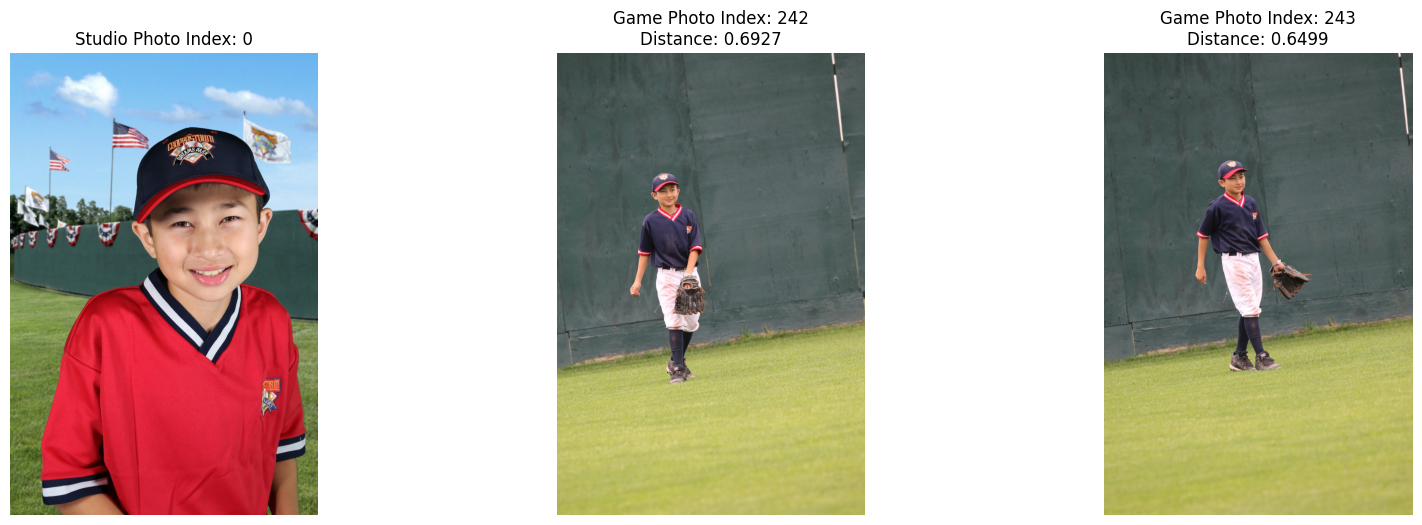

Matching game photos for studio photo index 1:
[(12, 0.77684927), (72, 0.6827973), (73, 0.7941479), (74, 0.7984919), (88, 0.7909093), (182, 0.7955099), (183, 0.63357395), (184, 0.76379985), (185, 0.7914011), (225, 0.78158695), (227, 0.78491575)]


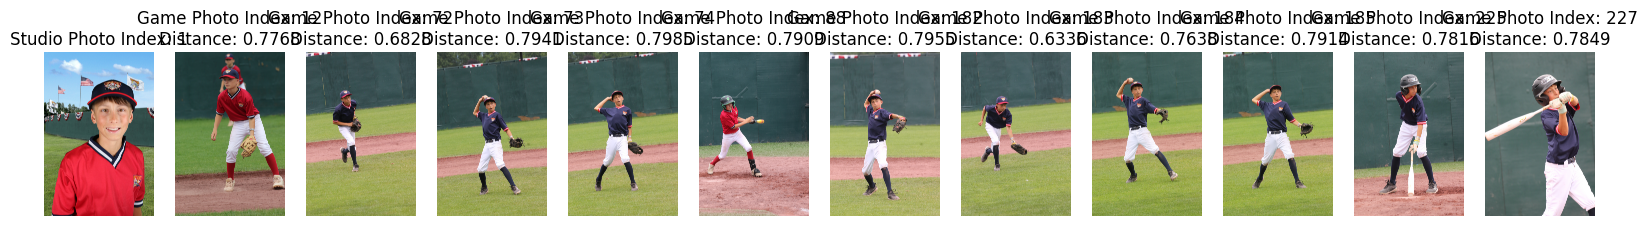

Matching game photos for studio photo index 2:
[(207, 0.7826202), (208, 0.69945055), (236, 0.7454691), (237, 0.73913145), (238, 0.6597637), (239, 0.7037191), (256, 0.64778155)]


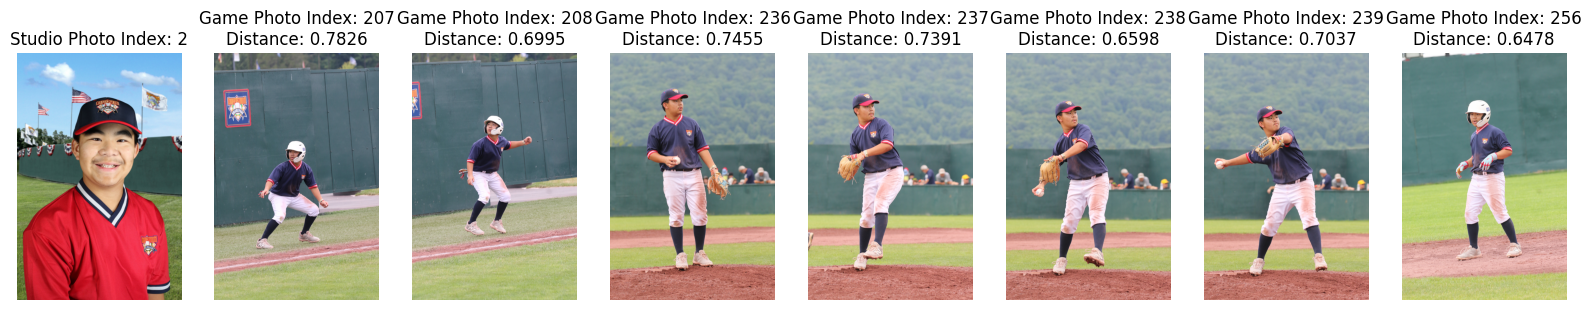

Matching game photos for studio photo index 3:
[]
No matches found.
Matching game photos for studio photo index 4:
[]
No matches found.
Matching game photos for studio photo index 5:
[(224, 0.69162333)]


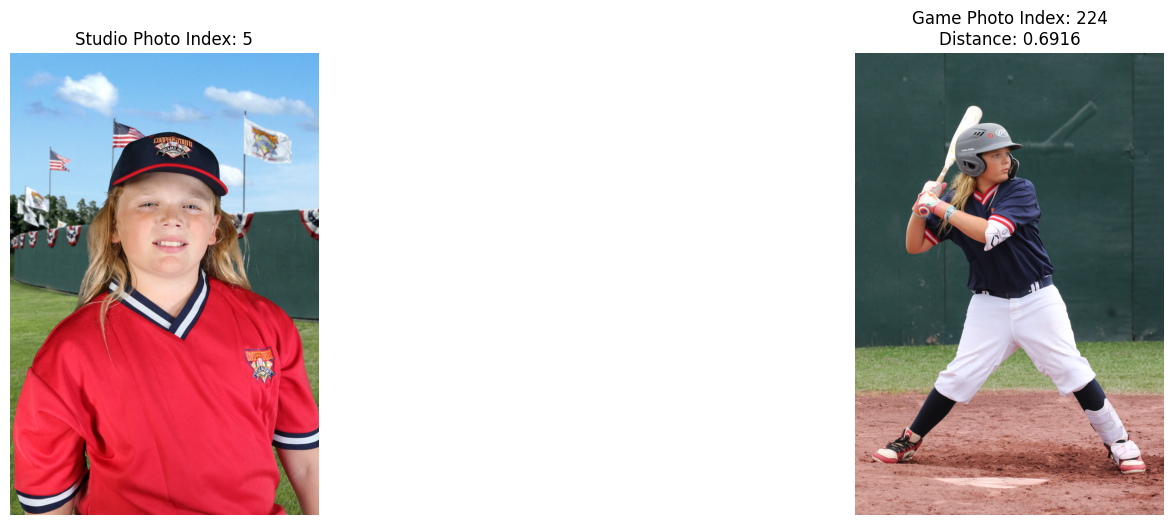

Matching game photos for studio photo index 6:
[(244, 0.76889277)]


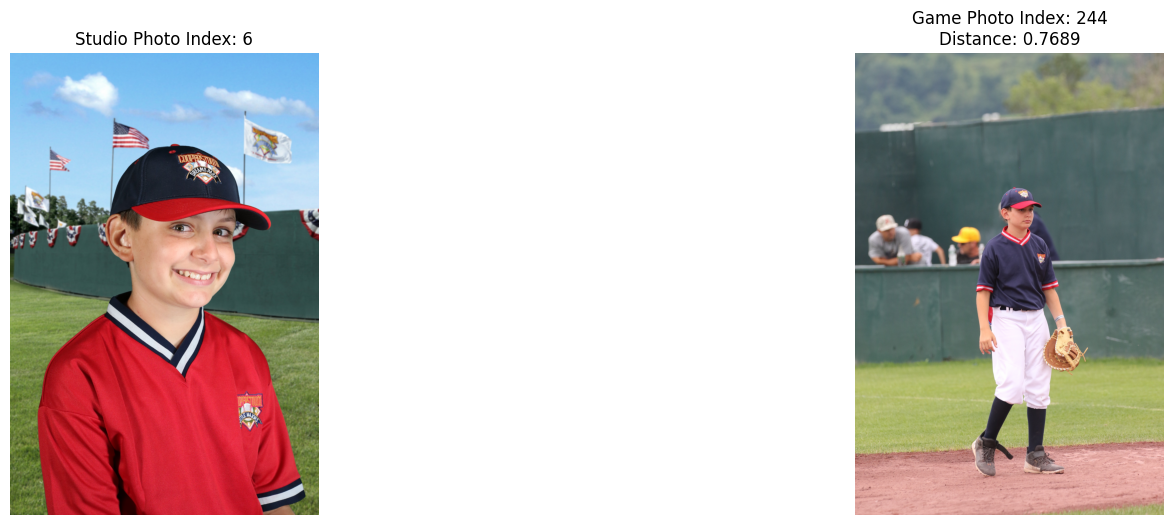

Matching game photos for studio photo index 7:
[(69, 0.5630747), (70, 0.47572076), (71, 0.48216656), (94, 0.4862718), (110, 0.4960475), (112, 0.47216445), (157, 0.7857959), (180, 0.6199936), (237, 0.7950088), (246, 0.5807529), (247, 0.68668354)]


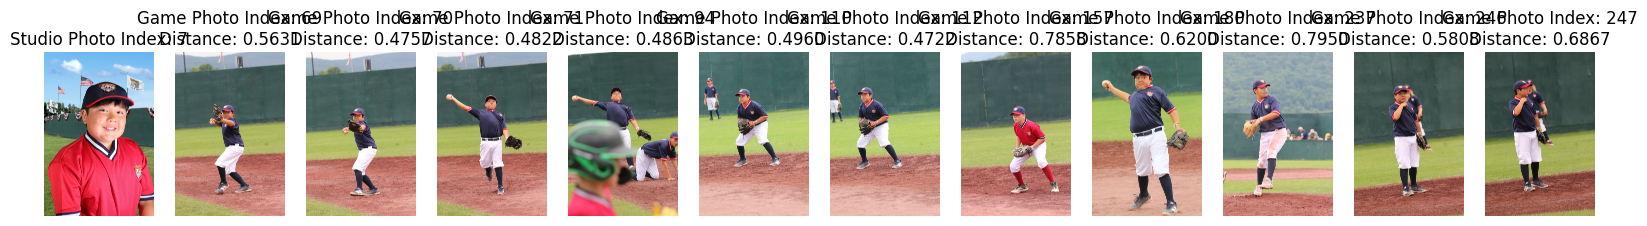

Matching game photos for studio photo index 8:
[]
No matches found.
Matching game photos for studio photo index 9:
[(235, 0.77994365)]


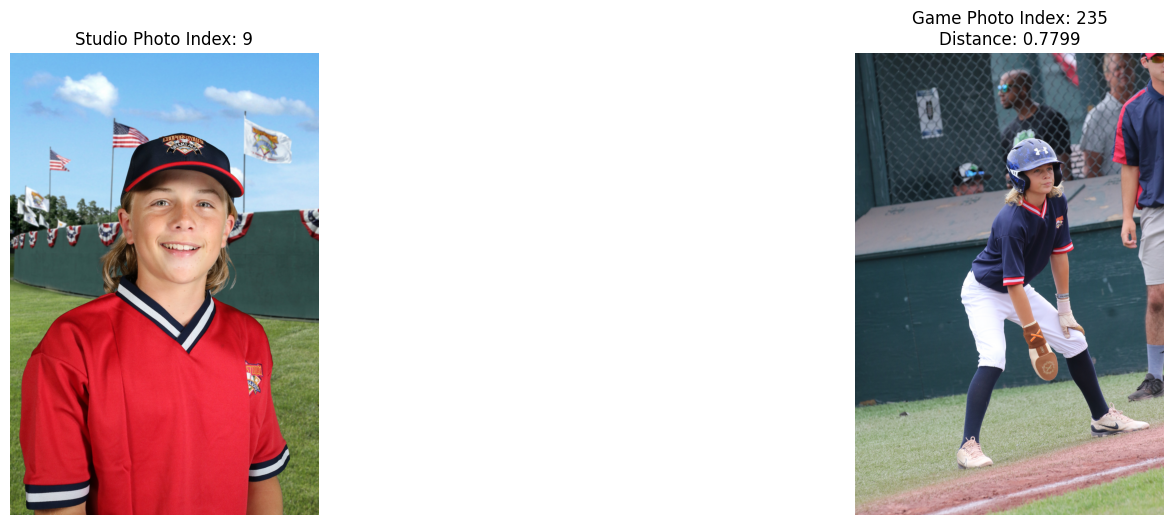

Matching game photos for studio photo index 10:
[]
No matches found.
Matching game photos for studio photo index 11:
[(301, 0.7234517)]


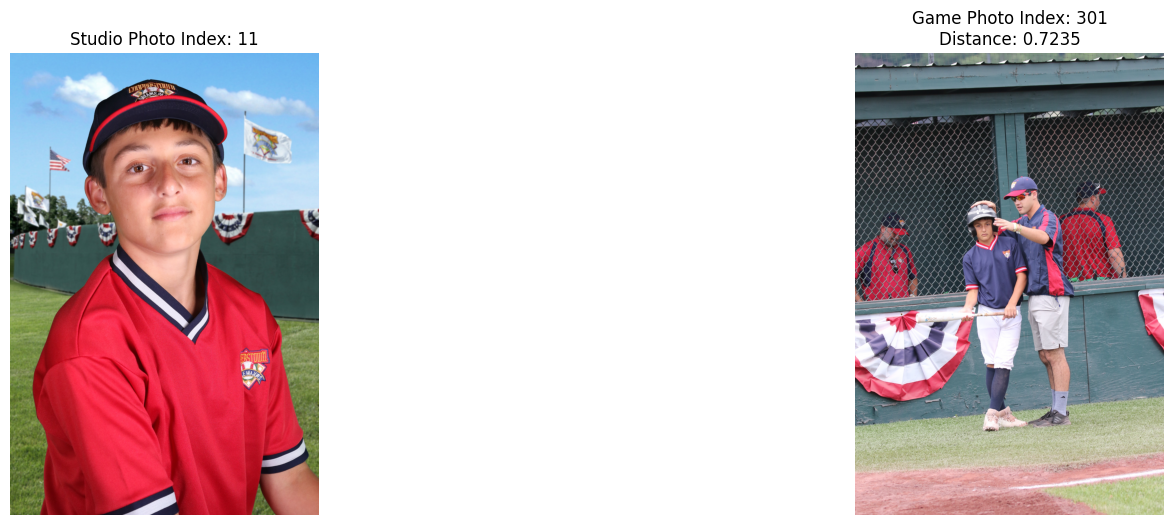

In [117]:
# Display results, but load and display the original images (using the file paths)
for studio_idx, matches in results.items():
    print(f'Matching game photos for studio photo index {studio_idx}:')
    print(matches)  # List of matched game photos (indices and distances)
    if matches:
        # Load and display the studio image using the file path
        studio_image = Image.open(studio_photos_paths[studio_idx])
        # Set up the plot for studio and matched game images
        plt.figure(figsize=(20, 6))
        plt.subplot(1, len(matches) + 1, 1)
        plt.imshow(studio_image)
        plt.title(f'Studio Photo Index: {studio_idx}')
        plt.axis('off')
        # Display each matched game image using the original file path
        for i, (game_idx, distance) in enumerate(matches):
            game_image = Image.open(match_photos_paths[game_idx])  # Load the match image by path
            plt.subplot(1, len(matches) + 1, i + 2)
            plt.imshow(game_image)
            plt.title(f'Game Photo Index: {game_idx}\nDistance: {distance:.4f}')
            plt.axis('off')
        # Show the plot with studio and match images
        plt.show()
    else:
        print("No matches found.")